# 4.1 First Retrieval Model

In [1]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs

Load data and metadata:

In [2]:
train_df = pd.read_csv('../local_data/train_data.csv', header=0)
test_df = pd.read_csv('../local_data/test_data.csv', header=0)
with open('../local_data/metadata.json', 'r') as f:
    metadata = json.load(f)

In [3]:
all_users = [str(int(i)) for i in metadata['users']]
all_movies = [str(int(i)) for i in metadata['movies']]
all_cities = metadata['cities']
all_states = metadata['states']
na_value = metadata['string_na']

The retrieval model in TFRS is adjusted to be trained with implicit feedback. We'll use all training samples which user liked, which willbe rating of 3 stars or more. 

In [4]:
train_df_liked = train_df[train_df['rating'] >= 3]
test_df_liked = test_df[test_df['rating'] >= 3]

In [5]:
def convert_to_dataset(df):
    d = {k:v.to_numpy() for k,v in dict(df).items() if k in ['user','city','state','movie']}
    return tf.data.Dataset.from_tensor_slices(d)

train_dataset = convert_to_dataset(train_df_liked)
test_dataset = convert_to_dataset(test_df_liked)

The following is a list of all movies the model should recognize, which will be used for the retrieval task.

In [6]:
movies_candidates = tf.data.Dataset.from_tensor_slices({'movie': train_df['movie'].unique()}).map(lambda x: x['movie']).batch(200).map(tf.strings.as_string)

Below is the implementation of the retrieval model. Note it is made of two separate models, which only interact as part of the Task. Also, as we'll call the model in unique way to retrieval models, there's no need to implement `call()`.

In [7]:
class MoviesRetrievalModel(tfrs.models.Model):
    def __init__(self):
        super().__init__()
        
        large_embedding_size = 20
        medium_embedding_size = 5
        small_embedding_size = 3
        last_layer_size = 20
        
        # User Model
        
        self.user_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='user_input')
        self.user_sl = tf.keras.layers.StringLookup(vocabulary=all_users, name='user_string_lookup')(self.user_input)
        self.user_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_users)+1, large_embedding_size, name='user_emb')(self.user_sl), axis=1)
        
        self.city_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='city_input')
        self.city_sl = tf.keras.layers.StringLookup(vocabulary=all_cities, mask_token=na_value, name='city_string_lookup')(self.city_input)
        self.city_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_cities)+2, medium_embedding_size, name='city_emb')(self.city_sl), axis=1)
        
        self.state_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='state_input')
        self.state_sl = tf.keras.layers.StringLookup(vocabulary=all_states, mask_token=na_value, name='state_string_lookup')(self.state_input)
        self.state_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_states)+2, small_embedding_size, name='state_emb')(self.state_sl), axis=1)
        
        self.user_merged = tf.keras.layers.concatenate([self.user_emb, self.city_emb, self.state_emb], 
                                                       axis=-1, name='user_merged')
        self.user_dense = tf.keras.layers.Dense(last_layer_size, activation='relu', name='user_dense')(self.user_merged)
        
        self.user_model = tf.keras.Model(inputs={'user': self.user_input,
                                                 'city': self.city_input,
                                                 'state': self.state_input},
                                         outputs=self.user_dense)
        
        
        # Movie Model
        
        self.movie_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='movie_input ')
        self.movie_sl = tf.keras.layers.StringLookup(vocabulary=all_movies, name='movie_string_lookup')(self.movie_input)
        self.movie_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_movies)+1, last_layer_size, name='movie_emb')(self.movie_sl), axis=1)
        
        self.movie_model = tf.keras.Model(inputs={'movie': self.movie_input},
                                          outputs=self.movie_emb)
        
        
        # Task
        
        task_candidates = movies_candidates.map(self.movie_model)  
        top_k_metrics = [tf.keras.metrics.TopKCategoricalAccuracy(k=x, name=f'top_{x}_categorical_accuracy') for x in [10, 100]]
        task_metric = tfrs.metrics.FactorizedTopK(candidates=task_candidates, metrics=top_k_metrics)
        self.task = tfrs.tasks.Retrieval(metrics=task_metric)  # Default loss: tf.keras.losses.CategoricalCrossentropy
        
    
    def compute_loss(self, features, training=False):
        return self.task(
            self.user_model({'user': tf.strings.as_string(features["user"]), 
                             'city': features["city"],
                             'state': features["state"]}),
            self.movie_model(tf.strings.as_string(features["movie"]))
        )

In [8]:
model = MoviesRetrievalModel()
learning_rate = 1e-1
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=learning_rate))
cached_train = train_dataset.shuffle(15_000).batch(10_000).cache()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=3)
model.fit(cached_train, epochs=10, callbacks=[early_stopping])

Epoch 1/10
80/80 [==============================] - 76s 934ms/step - top_10_categorical_accuracy: 0.0160 - top_100_categorical_accuracy: 0.1310 - loss: 90110.9673 - regularization_loss: 0.0000e+00 - total_loss: 90110.9673
Epoch 2/10
80/80 [==============================] - 74s 925ms/step - top_10_categorical_accuracy: 0.0179 - top_100_categorical_accuracy: 0.1580 - loss: 89316.2434 - regularization_loss: 0.0000e+00 - total_loss: 89316.2434
Epoch 3/10
80/80 [==============================] - 73s 913ms/step - top_10_categorical_accuracy: 0.0183 - top_100_categorical_accuracy: 0.1711 - loss: 88861.5248 - regularization_loss: 0.0000e+00 - total_loss: 88861.5248
Epoch 4/10
80/80 [==============================] - 74s 924ms/step - top_10_categorical_accuracy: 0.0194 - top_100_categorical_accuracy: 0.1770 - loss: 88602.1084 - regularization_loss: 0.0000e+00 - total_loss: 88602.1084
Epoch 5/10
80/80 [==============================] - 75s 942ms/step - top_10_categorical_accuracy: 0.0196 - top_1

In [9]:
cached_test = test_dataset.batch(5000).cache()
model.evaluate(cached_test, return_dict=True)

9/9 [==============================] - 3s 352ms/step - top_10_categorical_accuracy: 0.0208 - top_100_categorical_accuracy: 0.1874 - loss: 35770.5689 - regularization_loss: 0.0000e+00 - total_loss: 35770.5689


{'top_10_categorical_accuracy': 0.02080344408750534,
 'top_100_categorical_accuracy': 0.18737445771694183,
 'loss': 13374.6318359375,
 'regularization_loss': 0,
 'total_loss': 13374.6318359375}

The model get the right match as part of its top 10 recommendations in 2% of the cases, and at the top 100 recommendations in 19% of the cases.

Next, it's time to call the model for predictions. We use a special layer on top of the model to get a list of top movies per user. We supply the layer with the output of the user model (which is the user embedding), and build an index using movie embeddings.

In [10]:
retrieval = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
retrieval.index_from_dataset(
  tf.data.Dataset.zip((movies_candidates, movies_candidates.map(model.movie_model)))
)

Let's see how it works. We'll select a testing user for this demo.

In [11]:
test_df.head(1)[['user','city','state']]

,user,city,state
0,6040,Astoria,NY


We pass the extra layer we've just defined the features of the user, and recieve a list of top movies fot that user:

In [12]:
retrieval([tf.constant(['6040']), tf.constant(['Astoria']), tf.constant(['NY'])])[1].numpy()[0]

array([b'3593', b'3753', b'3798', b'260', b'2881', b'2013', b'3615',
       b'3555', b'1210', b'2827'], dtype=object)

Save model weights and plots:

In [13]:
model.save_weights('weights_4_1/p41')

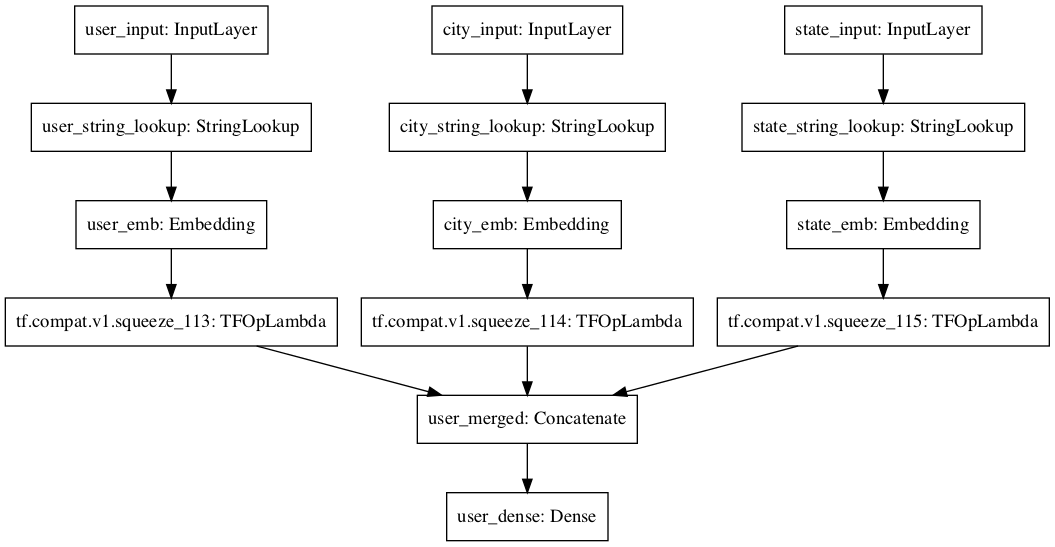

In [14]:
tf.keras.utils.plot_model(model.user_model, to_file="project_4_1_user.png")

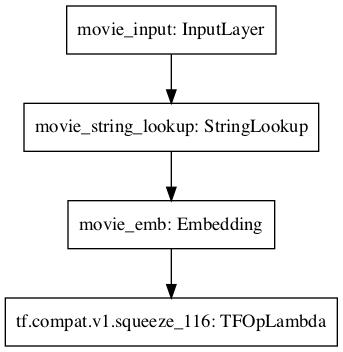

In [15]:
tf.keras.utils.plot_model(model.movie_model, to_file="project_4_1_movie.png")

In [16]:
model.user_model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
city_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_string_lookup (StringLooku (None, 1)            0           user_input[0][0]                 
__________________________________________________________________________________________________
city_string_lookup (StringLooku (None, 1)            0           city_input[0][0]                 
___________________________________________________________________________________________

In [17]:
model.movie_model.summary()

Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
movie_input (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
movie_string_lookup (StringL (None, 1)                 0         
_________________________________________________________________
movie_emb (Embedding)        (None, 1, 20)             24020     
_________________________________________________________________
tf.compat.v1.squeeze_116 (TF (None, 20)                0         
Total params: 24,020
Trainable params: 24,020
Non-trainable params: 0
_________________________________________________________________
